# Topic Modeling on Repository Artifacts

This notebook applies Latent Dirichlet Allocation (LDA) to your mined repository data (Commits & PRs) using your custom preprocessing pipeline.

In [59]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess

# Setup Paths
BASE = Path("/Users/lukas./Desktop/CMPUT660Project/inputs/processed")

# Configuration
NUM_TOPICS = 5  # Number of topics to discover
PASSES = 10     # Training epochs (higher = better quality, slower)

## 1. Load Data
Loading commits and PR bodies, normalizing dates, and sorting chronologically.

In [60]:
def load_and_prep(filename):
    fpath = BASE / filename
    if not fpath.exists():
        return pd.DataFrame()
  
    df = pd.read_parquet(fpath)

    # Normalize Date
    date_col = 'date' if 'date' in df.columns else 'created_at'
    if date_col in df.columns:
        df['date'] = pd.to_datetime(df[date_col])
    
    # Normalize Text
    if 'text' in df.columns:
        df = df[['date', 'text']].dropna()
        # Tag the period based on filename
        if "before" in filename:
            df['period'] = 'Before'
        else:
            df['period'] = 'After'
        return df
    return pd.DataFrame()

# Load all relevant files
files = [
    "commit_messages_before.parquet", "commit_messages_after.parquet",
    "pr_bodies_before.parquet", "pr_bodies_after.parquet"
]

dfs = [load_and_prep(f) for f in files]
full_df = pd.concat(dfs)

# SORT BY DATE (Crucial for time-series plotting)
full_df = full_df.sort_values(by="date")

print(f"Loaded {len(full_df):,} documents.")
print(f"Date Range: {full_df['date'].min()} to {full_df['date'].max()}")

# Extract text as list
documents = full_df['text'].astype(str).tolist()
dates = full_df['date'].tolist()
periods = full_df['period'].tolist()  # Keep track of labels

Loaded 44,494 documents.
Date Range: 2010-09-12 09:08:11+00:00 to 2025-11-24 12:29:23+00:00


## 2. Preprocessing
Applying custom filters (stripping tags, punctuation, numeric) and removing stopwords.

In [61]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import preprocess_string # splitting 
from gensim.corpora.dictionary import Dictionary # build vocabular
from gensim.parsing.preprocessing import (
    remove_stopwords,
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    preprocess_string
)
from gensim.parsing.porter import PorterStemmer
from gensim.corpora.dictionary import Dictionary

# --- Custom Stopwords (Dev-Specific Noise) ---
CUSTOM_STOPWORDS = {
    "https", "http", "www", "com", "org", "io",
    "v", "d", "e", "l", "u", "r",
    "git", "github",
}

# --- Basic Cleaning Filters ---
CUSTOM_FILTERS = [
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric
]




# Initial stopword removal
processed_docs = [remove_stopwords(doc.lower()) for doc in documents]

CUSTOM_FILTERS = [strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]

tokenized = [preprocess_string(text, CUSTOM_FILTERS) for text in processed_docs]

tokenized = [
    [t for t in doc if t not in CUSTOM_STOPWORDS and len(t) > 2]
    for doc in tokenized
]

# Stemming doesn't always help
stemmer = PorterStemmer()



def stem_document(p,doc):
    return [p.stem(word) for word in doc]

stemmed = [stem_document(stemmer,doc) for doc in tokenized]

from gensim.models import Phrases
from gensim.models.phrases import Phraser

bigram = Phrases(tokenized, min_count=20, threshold=15)
bigram_phraser = Phraser(bigram)
tokenized = [bigram_phraser[doc] for doc in tokenized]

    
# # disable stemming (Using your logic to overwrite)
stemmed = tokenized

## 3. Train LDA Model
Building the dictionary, filtering extremes, and training the model.

In [62]:
vocab = Dictionary( stemmed )
print(f"Initial vocab size: {len(vocab)}")

vocab.filter_extremes(
    no_below=25,    # remove very rare junk
    no_above=0.5,   # remove ultra-common boilerplate
    keep_n=8000     # cap vocab size hard
)

print(f"Filtered vocab size: {len(vocab)}")

corpus = [vocab.doc2bow(doc) for doc in stemmed]

ALPHA = 0.01
BETA = 0.01
PASSES = 10
TOPICS = 6

dumb_dictionary_bug = vocab[0]
id2word = vocab.id2token

print("Training LDA Model...")
lda = gensim.models.LdaModel(
    corpus,
    num_topics=TOPICS,
    id2word=id2word,
    passes=PASSES,
    alpha=ALPHA,
    eval_every=5,
    eta=BETA
)

# Print Topics
for idx, topic in lda.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

Initial vocab size: 32565
Filtered vocab size: 3146
Training LDA Model...
Topic: 0 
Words: 0.187*"fix" + 0.077*"merge_pull" + 0.048*"refactor" + 0.030*"remove" + 0.019*"path" + 0.018*"implement" + 0.017*"import" + 0.016*"issue" + 0.015*"use" + 0.015*"project"

Topic: 1 
Words: 0.068*"add" + 0.034*"added" + 0.030*"merge_pull" + 0.023*"java" + 0.021*"for" + 0.020*"users" + 0.018*"documentation" + 0.015*"method" + 0.014*"fixes" + 0.014*"helper"

Topic: 2 
Words: 0.080*"user" + 0.033*"changes" + 0.030*"changelog" + 0.030*"release" + 0.030*"status" + 0.026*"position" + 0.024*"security" + 0.022*"core" + 0.019*"updates" + 0.017*"adjust"

Topic: 3 
Words: 0.067*"summary" + 0.033*"test" + 0.031*"add" + 0.030*"testing" + 0.027*"data" + 0.025*"use" + 0.024*"new" + 0.022*"run" + 0.019*"fix" + 0.016*"check"

Topic: 4 
Words: 0.138*"update" + 0.043*"docs" + 0.037*"add" + 0.036*"merge_pull" + 0.031*"readme" + 0.031*"configuration" + 0.030*"script" + 0.030*"services" + 0.030*"improve" + 0.027*"api"

T

## 4. Map Documents to Topics & Visualize
Here we convert the model output into a dense matrix and plot the topic trends over time.

In [63]:
# Initialize a matrix of shape (Num Topics, Num Documents)
# We transpose it so row=Topic, col=Time/Document
document_topics = np.zeros((TOPICS, len(corpus)))

for i, doc_bow in enumerate(corpus):
    topic_probs = lda.get_document_topics(doc_bow)
    for topic_id, prob in topic_probs:
        document_topics[topic_id, i] = prob

print("Document-Topic Matrix Shape:", document_topics.shape)

Document-Topic Matrix Shape: (6, 44494)


## 5. Visualizing Topics Over Time
We plot the moving average of topic probabilities. 
**Red Line:** Marks the start of the 'After' period (Agent Introduction).

Agent Introduction Date: 2024-12-28 01:42:59+00:00


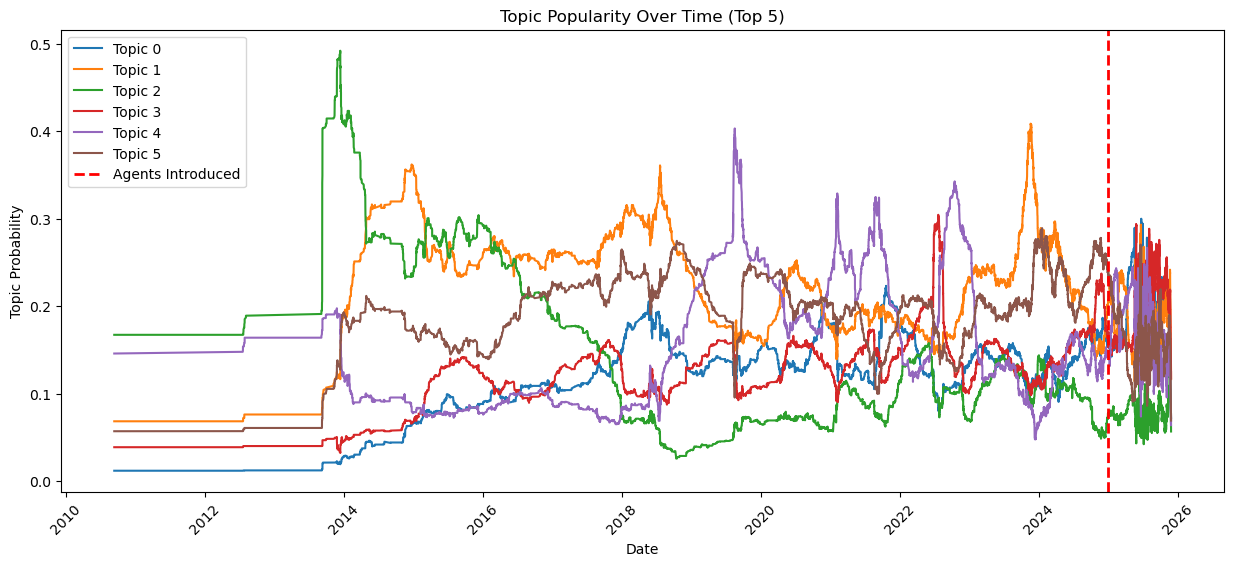

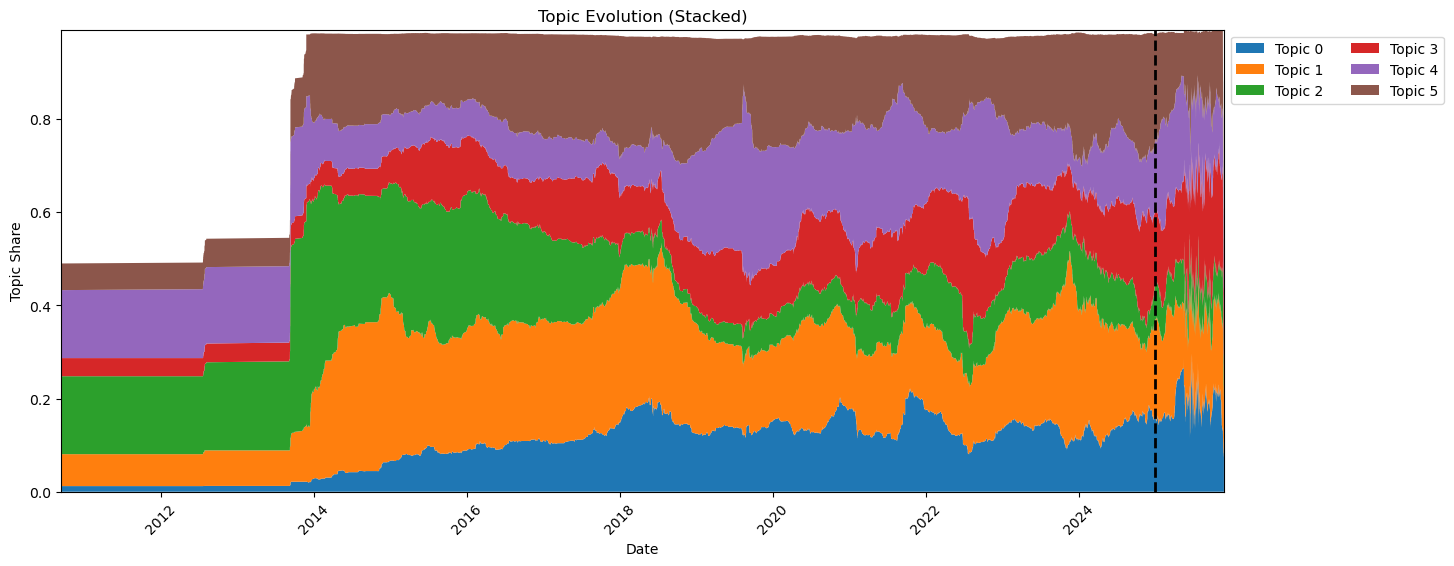

In [65]:
def moving_average(X, bins):
    # Pad to keep shape consistent
    pad_width = bins // 2
    return np.convolve(X, np.ones(bins)/bins, mode='same')

N = document_topics.shape[1]
ind = np.arange(N)
WINDOW = 500  # Smoothing window (adjust based on data volume)

# Find transition index (first occurrence of 'After')
try:
    transition_idx = periods.index('After')
    transition_date = dates[transition_idx]
    print(f"Agent Introduction Date: {transition_date}")
except ValueError:
    transition_date = None


# --- 1. Line Plot (Top 5 Topics for clarity) ---
plt.figure(figsize=(15, 6))
for i in range(TOPICS):  # Plotting top 5 topics to avoid clutter
    plt.plot(dates, moving_average(document_topics[i, :], WINDOW), label=f'Topic {i}')

if transition_date:
    plt.axvline(transition_date, color='r', linestyle='--', linewidth=2, label='Agents Introduced')

plt.legend()
plt.title("Topic Popularity Over Time (Top 5)")
plt.xlabel("Date")
plt.ylabel("Topic Probability")
plt.xticks(rotation=45)
plt.show()

# --- 2. Stacked Area Chart (Evolution) ---
mavg = np.array([
    moving_average(document_topics[i, :], WINDOW) for i in range(TOPICS)
])

plt.figure(figsize=(15, 6))
plt.stackplot(dates, mavg, labels=[f"Topic {i}" for i in range(TOPICS)])

if transition_date:
    plt.axvline(transition_date, color='black', linestyle='--', linewidth=2)

# Legend might be too big for 20 topics, consider hiding it or putting it outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2) 
plt.title("Topic Evolution (Stacked)")
plt.xlabel("Date")
plt.ylabel("Topic Share")
plt.margins(0,0)
plt.xticks(rotation=45)
plt.show()

## 6. Comparative Analysis: Before vs After
This section explicitly answers: **"How did topic prevalence change?"**

We calculate the average probability of each topic in the 'Before' period vs the 'After' period and plot them side-by-side.

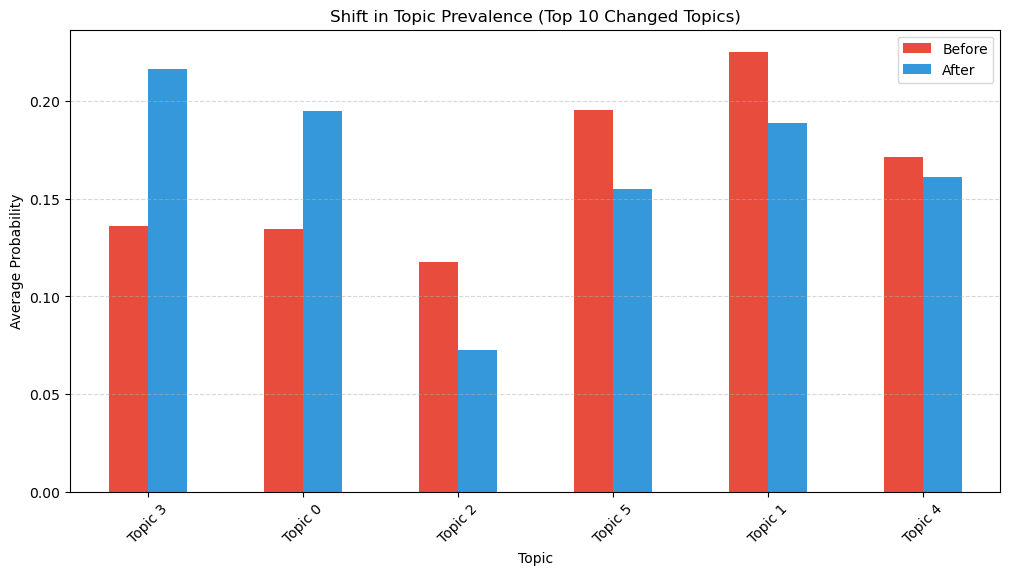

In [66]:
# Create masks for numpy slicing
is_before = np.array([p == 'Before' for p in periods])
is_after = np.array([p == 'After' for p in periods])

# Calculate mean probability for each topic in each period
topic_means_before = document_topics[:, is_before].mean(axis=1)
topic_means_after = document_topics[:, is_after].mean(axis=1)

# Prepare DataFrame for plotting
comparison_df = pd.DataFrame({
    'Topic': [f"Topic {i}" for i in range(TOPICS)],
    'Before': topic_means_before,
    'After': topic_means_after
})

# Sort by biggest difference (optional)
comparison_df['Diff'] = abs(comparison_df['After'] - comparison_df['Before'])
comparison_df = comparison_df.sort_values('Diff', ascending=False)

# Plot
comparison_df.head(10).plot(x='Topic', y=['Before', 'After'], kind='bar', figsize=(12, 6), color=['#E74C3C', '#3498DB'])
plt.title("Shift in Topic Prevalence (Top 10 Changed Topics)")
plt.ylabel("Average Probability")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

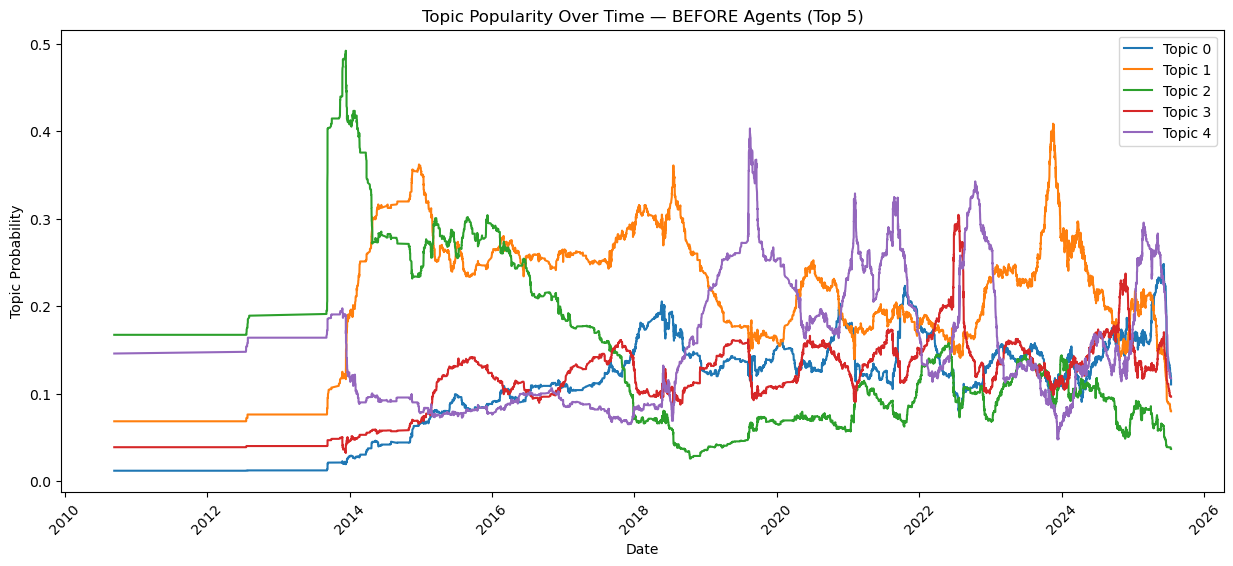

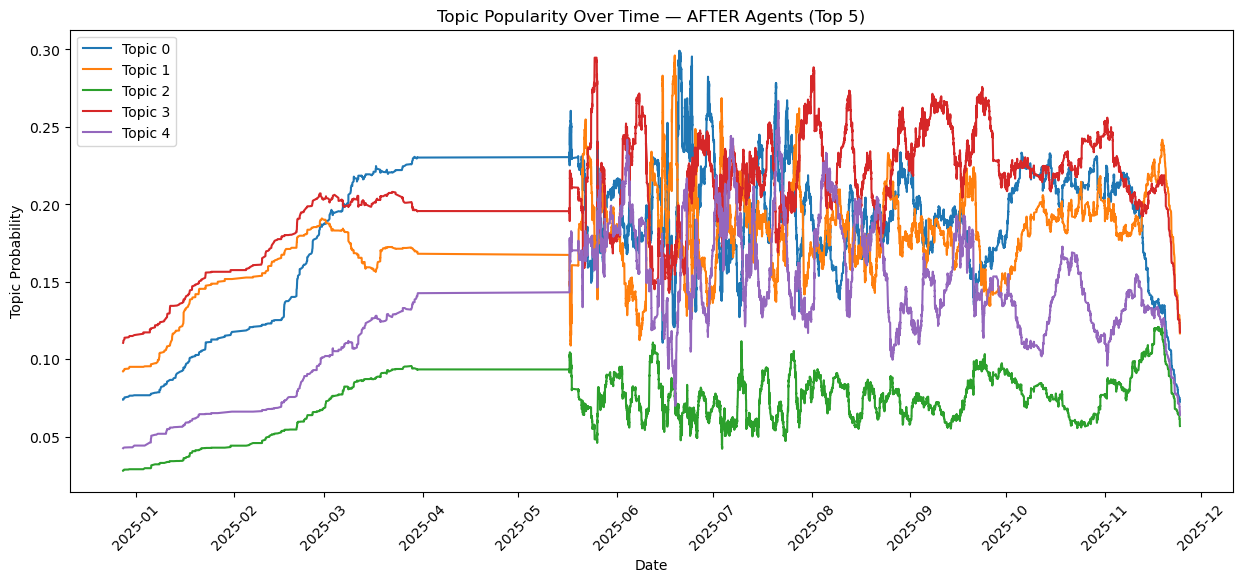

In [67]:
# --- 3. Line Plot (Top 5 Topics — BEFORE only) ---
plt.figure(figsize=(15, 6))
for i in range(min(5, TOPICS)):
    plt.plot(
        np.array(dates)[is_before],
        moving_average(document_topics[i, is_before], WINDOW),
        label=f'Topic {i}'
    )

plt.legend()
plt.title("Topic Popularity Over Time — BEFORE Agents (Top 5)")
plt.xlabel("Date")
plt.ylabel("Topic Probability")
plt.xticks(rotation=45)
plt.show()


# --- 4. Line Plot (Top 5 Topics — AFTER only) ---
plt.figure(figsize=(15, 6))
for i in range(min(5, TOPICS)):
    plt.plot(
        np.array(dates)[is_after],
        moving_average(document_topics[i, is_after], WINDOW),
        label=f'Topic {i}'
    )

plt.legend()
plt.title("Topic Popularity Over Time — AFTER Agents (Top 5)")
plt.xlabel("Date")
plt.ylabel("Topic Probability")
plt.xticks(rotation=45)
plt.show()
